In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder 

In [24]:
df=pd.read_csv("fraud.csv")

In [25]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [26]:
df.drop(columns=["isFlaggedFraud"],inplace=True)

In [27]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [28]:
def outlier(df,value):
    q1=df[value].quantile(0.25)
    q3= df[value].quantile(0.75)
    IQR = q3-q1
    wisker1 = q1-1.5*IQR
    wisker2 = q3+1.5*IQR
    return wisker1,wisker2

columns=["step","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
for column in columns:
    wisker1,wisker2= outlier(df,column)
    df=df[(df[column]>=wisker1) & (df[column]<=wisker2)]
    print(wisker1)
    print(wisker2)

-112.5
603.5
-279631.29
501793.53
-170051.17875
283418.63125
-35955.915
59926.525
-1049565.0787499999
1749275.1312499999
-763714.81125
1272858.01875


In [29]:
df["isFraud"].value_counts()


isFraud
0    3196840
1       2452
Name: count, dtype: int64

In [46]:
label_encoder = LabelEncoder()

for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,3,1864.28,1736,21249.0,19384.72,3665,0.0,0.00,0
1,1,3,11668.14,2773,41554.0,29885.86,2900,0.0,0.00,0
2,1,3,7817.71,4630,53860.0,46042.29,4088,0.0,0.00,0
3,1,3,4024.36,707,2671.0,0.00,2848,0.0,0.00,0
4,1,2,5337.77,4162,41720.0,36382.23,1336,41898.0,40348.79,0


In [36]:
df_1 = df[df['isFraud'] == 0].iloc[:2452]
df_0 = df[df['isFraud'] ==1 ]

# Concatenate the slices
df = pd.concat([df_1, df_0]).reset_index(drop=True)
df["isFraud"].value_counts()

isFraud
0    2452
1    2452
Name: count, dtype: int64

In [37]:
x=df.drop(columns=["isFraud"])
y=df["isFraud"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

# future engineering

In [40]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression



x_train=PCA(n_components=4).fit_transform(x_train)
x_test=PCA(n_components=4).fit_transform(x_test)
new = LogisticRegression()
clf=new.fit(x_train,y_train)
pre=clf.predict(x_test)


In [41]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,pre)

0.7951070336391437

In [42]:
from sklearn.metrics import classification_report, roc_curve, auc
report=classification_report(y_test,pre)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       504
           1       0.84      0.71      0.77       477

    accuracy                           0.80       981
   macro avg       0.80      0.79      0.79       981
weighted avg       0.80      0.80      0.79       981



# random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
fit_model=rf_classifier.fit(x_train, y_train)
y_pred = fit_model.predict(x_test)

In [53]:
from sklearn.metrics import classification_report, roc_curve, auc
report=classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       504
           1       0.87      0.87      0.87       477

    accuracy                           0.88       981
   macro avg       0.88      0.88      0.88       981
weighted avg       0.88      0.88      0.88       981



# next using grid search for random forest

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]        # Minimum number of samples required to be at a leaf node
}

grid_search=GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5,n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)
pred=grid_search.predict(x_test)

report=classification_report(y_test,pred)
print(report)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

           0       0.82      0.92      0.86       504
           1       0.90      0.78      0.84       477

    accuracy                           0.85       981
   macro avg       0.86      0.85      0.85       981
weighted avg       0.86      0.85      0.85       981



# next using grid search for logical regression

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],                  # Regularization strength
    'penalty': ['l1', 'l2'],                  # Type of regularization
    'solver': ['liblinear', 'saga']           # Optimization algorithm
}

grid_search=GridSearchCV(estimator=LogisticRegression(),param_grid=param_grid,cv=5,n_jobs=-1,verbose=2)
grid_search.fit(x_train,y_train)

predicted=grid_search.predict(x_test)

report=classification_report(y_test,predicted)
print(report)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       504
           1       0.84      0.71      0.77       477

    accuracy                           0.80       981
   macro avg       0.80      0.79      0.79       981
weighted avg       0.80      0.80      0.79       981



In [71]:
#compare all model randam forest along with grid search give more accuracy but more or less equally logestic regression
#  give good accuracy and take less time so we build a model in logestic regression

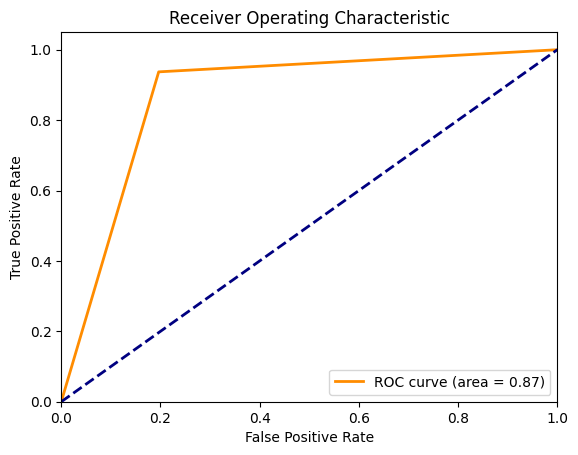

In [69]:
#roc curve of logesstic regression
fpr, tpr, _ = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()